# Content and Objectives

- Illustrate energies of energy detection
- Show histogram of received values

# Import

In [1]:
# importing
import numpy as np
from scipy import signal, special

import matplotlib.pyplot as plt
import matplotlib


In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=False)

matplotlib.rc('figure', figsize=(18, 8) )

# showing figures inline
%matplotlib inline

# Simulation of OOK

### some parameters first

In [3]:
# set parameters for received values

# degrees of freedom equalling length of pulse
# assuming virtual sampling time of 1
M = 16
t_s = 1
T_pulse = M * t_s

# number of realizations
N_real = int( 1e5 )

In [4]:
# define pulse as gaussian

# time vector per pulse
n_per_pulse = np.arange( 0, M)

# parameters of the RRC filter
# design is chosen such that interval length equals 6 sigma
sigma_pulse_2 = ( T_pulse / 6. )**2
gaussian_pulse = np.exp( - ( n_per_pulse - T_pulse/2 )**2 / 2 / sigma_pulse_2 )

# normalize to energy 1 first and change energy later
gaussian_pulse /= np.linalg.norm( gaussian_pulse )

sigma_Z_2 = 1

### Function for Determining the Threshold $\gamma_\mathrm{th}$

In [5]:
# function finding the decision threshold based on "theoretically comparing PDFs"
def get_threshold( pulse, Lambda, sigma_Z_2, N_real = int(1e5) ):

    # find M
    M = len( pulse )

    # theoretical PDFs´
    delta_y = 0.001
    y = np.arange( 0, 2 * sigma_Z_2 * ( M + Lambda ), delta_y )

    f_theo_0 = 1 / ( np.sqrt( 2**M ) * sigma_Z_2 * special.gamma( M/2) ) * ( y / sigma_Z_2 ) ** (M/2-1) * np.exp( - y / ( 2 * sigma_Z_2 ) )
    f_theo_1 = 1 / ( 2 * sigma_Z_2 ) * ( y / ( sigma_Z_2 * Lambda ) ) ** ( M/4 - 1/2 ) * np.exp( - ( y + Lambda * sigma_Z_2 ) / ( 2 * sigma_Z_2 ) ) * special.iv( M/2-1, np.sqrt( y * Lambda / sigma_Z_2 ) )

    # find ML rule by comparing PMFs and compare to theoretical results
    threshold = np.max( np.where( f_theo_0 > f_theo_1 ) )

    return threshold * delta_y

Lambda = 40

print( get_threshold( gaussian_pulse, Lambda, sigma_Z_2 ))
print('snr: ', 10*np.log10( Lambda/sigma_Z_2))

30.432000000000002
snr:  16.02059991327962


### Simulation of OOK for Different SNRs

In [6]:
# EbN0 values
Eb_N0_dB = np.arange( 0, 16, 2)
Eb_N0 = 10**( Eb_N0_dB / 10 )

# BER of OOK
ber_ook_sim = np.zeros_like( Eb_N0, dtype=float )
ber_ook_theo = np.zeros_like( Eb_N0, dtype=float )

# number of simulated bits
N_sim = int( 1e5 )

In [7]:
# loop along SNRs
for ind_EbN0, val_EbN0 in enumerate( Eb_N0 ):

    # init error counter and sim counter
    errors = 0
    sims = 0

    # get noise variance
    # NOTE: when doing simulations, pulse energy has be scaled in OOK
    sigma_Z_2 = 1
    N_0 = 2 * sigma_Z_2 * t_s

    E_b = val_EbN0 * N_0
    pulse_ook = gaussian_pulse * np.sqrt( 2 * E_b )    

    # find threshold
    Lambda = np.sum( pulse_ook **2 )

    # find detection threshold for ML energy detection
    gamma_th = get_threshold( gaussian_pulse, Lambda, sigma_Z_2 )

    # theoretical PDFs´
    delta_y = 0.001
    y = np.arange( 0, 2 * sigma_Z_2 * ( M + Lambda ), delta_y )
    f_theo_0 = 1 / ( np.sqrt( 2**M ) * sigma_Z_2 * special.gamma( M/2) ) * ( y / sigma_Z_2 ) ** (M/2-1) * np.exp( - y / ( 2 * sigma_Z_2 ) )
    f_theo_1 = 1 / ( 2 * sigma_Z_2 ) * ( y / ( sigma_Z_2 * Lambda ) ) ** ( M/4 - 1/2 ) * np.exp( - ( y + Lambda * sigma_Z_2 ) / ( 2 * sigma_Z_2 ) ) * special.iv( M/2-1, np.sqrt( y * Lambda / sigma_Z_2 ) )

    # theoretical error prob.
    p_error_0 = np.sum( f_theo_0[ int(gamma_th / delta_y ) : ] ) * delta_y
    p_error_1 = np.sum( f_theo_1[ : int(gamma_th / delta_y) ] ) * delta_y
    ber_ook_theo[ ind_EbN0 ] = .5 * p_error_0 + .5 * p_error_1


    # loop for bit realizations
    while errors < 200 and sims < N_sim:

        # sample bit and construct Tx signal
        b = np.random.randint( 2 )
        s = b * pulse_ook 

        # generate noise and construct received signal
        noise = np.sqrt( sigma_Z_2 ) * np.random.randn( M )
        r_OOK = s + noise

        # determine energy
        y = np.sum( np.abs( r_OOK )**2 )

        # perform ML decision by comparing against threshold
        b_ML = int( y > gamma_th )

        # increase counter
        errors += int( b_ML != b )
        sims += 1

    # assign error rate
    ber_ook_sim[ ind_EbN0 ] = errors / sims


<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/var/folders/gl/klr5r63x1n7gc51klm74k_900000gn/T/ipykernel_5978/2997521293.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$ E_\mathrm{b}/N_0$ (dB)')


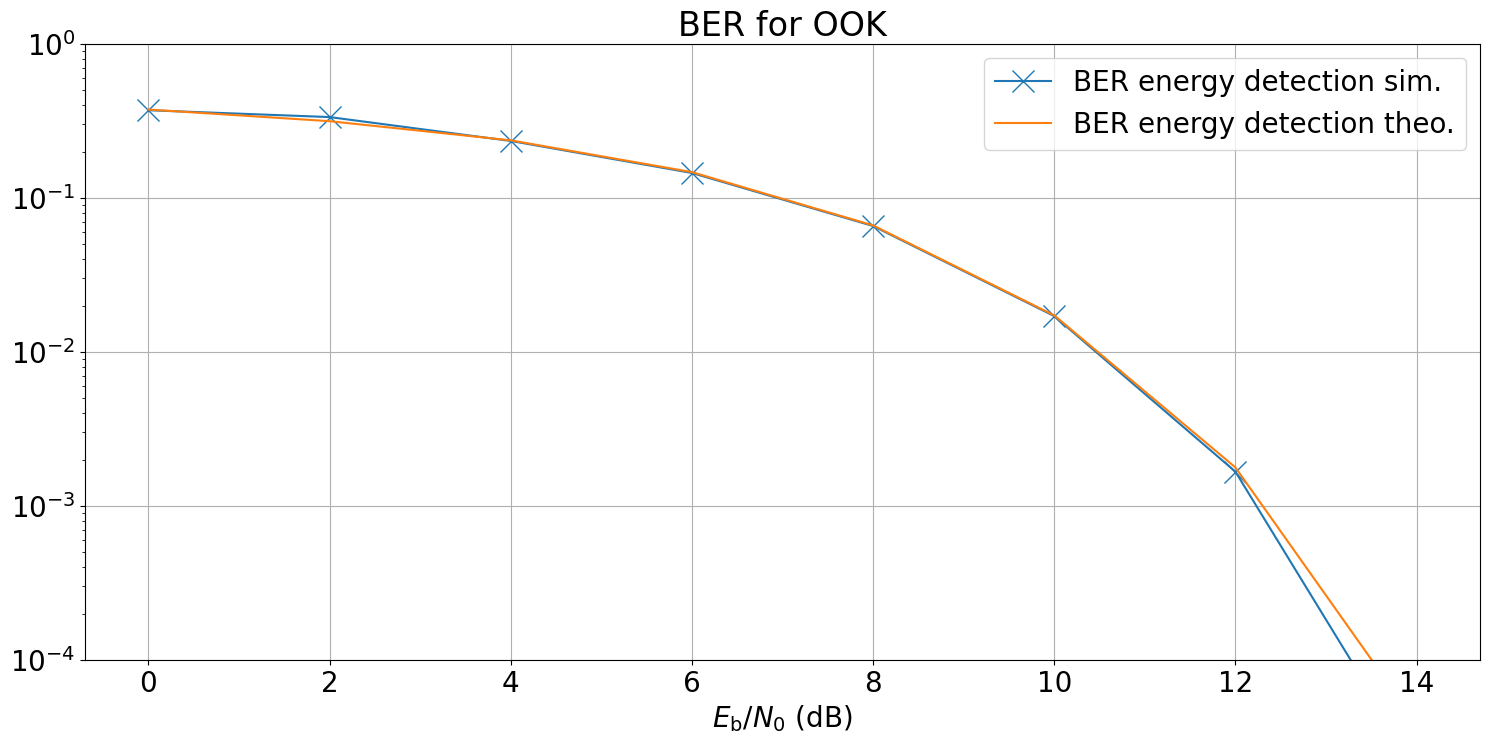

In [8]:
fig, ax = plt.subplots(1,1)

plt.semilogy( Eb_N0_dB, ber_ook_sim, '-x', ms=16, label='BER energy detection sim.' )
plt.semilogy( Eb_N0_dB, ber_ook_theo, label='BER energy detection theo.' )
plt.grid(1)
plt.legend()
ax.xaxis.get_major_locator().set_params(integer=True)
plt.ylim( 1e-4, 1)
plt.xlabel('$ E_\mathrm{b}/N_0$ (dB)')
# plt.xlim( 10, 15) 
plt.title('BER for OOK')
plt.show()

## Compare against coherent schemes using correlation

In [9]:
# EbN0 values
Eb_N0_dB = np.arange( 0, 16, 2)
Eb_N0 = 10**( Eb_N0_dB / 10 )

# BER of OOK
ber_ook_sim = np.zeros_like( Eb_N0, dtype=float )
ber_ook_theo = np.zeros_like( Eb_N0, dtype=float )
ber_ook_coherent = np.zeros_like( Eb_N0, dtype=float )

# number of simulated bits
N_sim = int( 1e5 )

In [10]:
# loop along SNRs
for ind_EbN0, val_EbN0 in enumerate( Eb_N0 ):

    # init error counter and sim counter
    errors = 0
    errors_coherent = 0
    sims = 0

    # get noise variance
    # NOTE: when doing simulations, pulse energy has be scaled in OOK
    sigma_Z_2 = 1 
    N_0 = 2 * sigma_Z_2 * t_s

    E_b = val_EbN0 * N_0
    pulse_ook = gaussian_pulse * np.sqrt( 2 * E_b )    

    # find threshold
    Lambda = np.sum( pulse_ook **2 )

    # find detection threshold for ML energy detection
    gamma_th = get_threshold( gaussian_pulse, Lambda, sigma_Z_2 )

    # theoretical PDFs´
    delta_y = 0.001
    y = np.arange( 0, 2 * sigma_Z_2 * ( M + Lambda ), delta_y )
    f_theo_0 = 1 / ( np.sqrt( 2**M ) * sigma_Z_2 * special.gamma( M/2) ) * ( y / sigma_Z_2 ) ** (M/2-1) * np.exp( - y / ( 2 * sigma_Z_2 ) )
    f_theo_1 = 1 / ( 2 * sigma_Z_2 ) * ( y / ( sigma_Z_2 * Lambda ) ) ** ( M/4 - 1/2 ) * np.exp( - ( y + Lambda * sigma_Z_2 ) / ( 2 * sigma_Z_2 ) ) * special.iv( M/2-1, np.sqrt( y * Lambda / sigma_Z_2 ) )

    # theoretical error prob.
    p_error_0 = np.sum( f_theo_0[ int(gamma_th / delta_y ) : ] ) * delta_y
    p_error_1 = np.sum( f_theo_1[ : int(gamma_th / delta_y) ] ) * delta_y
    ber_ook_theo[ ind_EbN0 ] = .5 * p_error_0 + .5 * p_error_1


    # loop for bit realizations
    while errors_coherent < 200 and sims < N_sim:

        # sample bit and construct Tx signal
        b = np.random.randint( 2 )
        s = b * pulse_ook 

        # generate noise and construct received signal
        noise = np.sqrt( sigma_Z_2 ) * np.random.randn( M )
        r_OOK = s + noise

        #####
        ### energy detection first
        #####
        
        # determine energy
        y = np.sum( np.abs( r_OOK )**2 )

        # perform ML decision by comparing against threshold
        b_ML_energy = int( y > gamma_th )

        # increase counter
        errors += int( b_ML_energy != b )

        #####
        ### coherent detection 
        #####

        # perform correlation
        correlation = np.correlate( r_OOK, pulse_ook )[0]
        # print( 'b= ', b, ', correlation= ', correlation, ', Lambda= ', Lambda)
        
        # coherent detection by correlation
        b_ML_coherent = int( correlation > Lambda/2 )
        
        # increase error couter (or not)
        errors_coherent += int (b_ML_coherent != b )

        # increase simulation counter
        sims += 1

    # assign error rate
    ber_ook_sim[ ind_EbN0 ] = errors / sims
    ber_ook_coherent[ ind_EbN0 ] = errors_coherent / sims


In [11]:
# Theoretical curve for OOK
n_int = 100
int_vals = np.linspace(0,np.pi/2,n_int+1)[1:] #remove starting point -> division by 0
# Theo curve: all real noise, using reformulation of Q-function 
ber_ook_coherent_theo = 1/np.pi*(np.pi/(2*n_int))* np.sum(np.exp(-np.outer(np.sqrt(Eb_N0)**2,1/(2*np.sin(int_vals**2)))),1)

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/var/folders/gl/klr5r63x1n7gc51klm74k_900000gn/T/ipykernel_5978/2774461424.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$ E_\mathrm{b}/N_0$ (dB)')


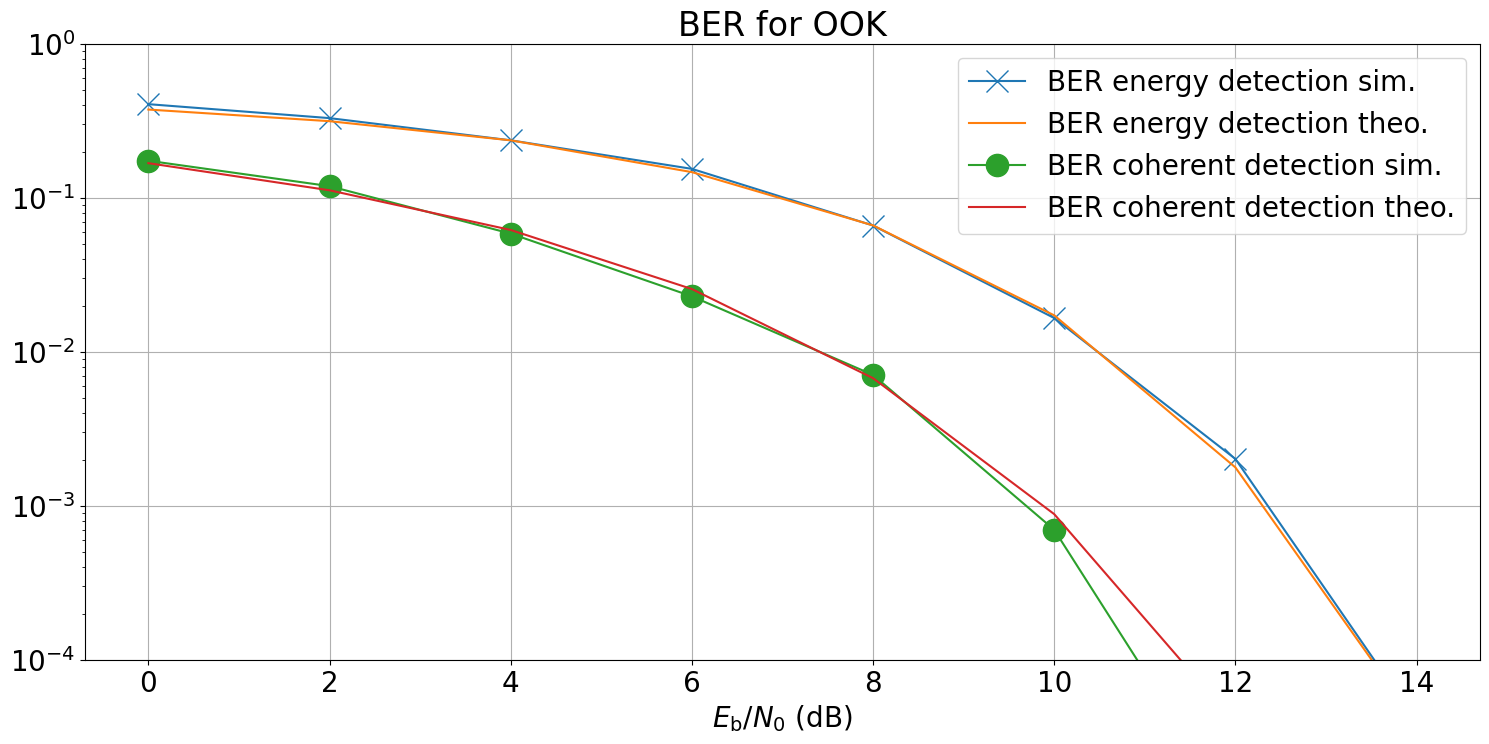

In [12]:
fig, ax = plt.subplots(1,1)

plt.semilogy( Eb_N0_dB, ber_ook_sim, '-x', ms=16, label='BER energy detection sim.' )
plt.semilogy( Eb_N0_dB, ber_ook_theo, label='BER energy detection theo.' )
plt.semilogy( Eb_N0_dB, ber_ook_coherent, '-o', ms=16, label='BER coherent detection sim.' )
plt.semilogy( Eb_N0_dB, ber_ook_coherent_theo, label='BER coherent detection theo.' )

plt.grid(1)
plt.legend()
ax.xaxis.get_major_locator().set_params(integer=True)
plt.ylim( 1e-4, 1)
plt.xlabel('$ E_\mathrm{b}/N_0$ (dB)')
plt.title('BER for OOK')
plt.show()

## Discrepancy between theoretical curve and simulations for coherent detection:
After the matched filter, the noise is not AWGN anymore. We optimize the *SNR* through matched filtering.
How well does the approximation hold for:
 * high or very low M?
 * a rectangular pulse shape?

# Simulation of PPM for Different SNRs

+ Would we mind doing it?!?

### change parameters first to match the nature of PPM

In [13]:
# set parameters for received values

# degrees of freedom equalling length of pulse
# assuming virtual sampling time of 1
M = 16
t_s = 1
T_pulse = M * t_s
T_PPM = 2 * T_pulse

# number of realizations
N_real = int( 1e5 )

In [14]:
# define pulse as gaussian

# time vector per pulse
n_per_pulse = np.arange( 0, M)

# parameters of the RRC filter
# design is chosen such that interval length equals 6 sigma
sigma_pulse_2 = ( T_pulse / 6. )**2
gaussian_pulse = np.exp( - ( n_per_pulse - T_pulse/2 )**2 / 2 / sigma_pulse_2 )

# normalize to energy 1 first and change energy later
gaussian_pulse /= np.linalg.norm( gaussian_pulse )

In [15]:
# EbN0 values
Eb_N0_dB = np.arange( 0, 16, 2)
Eb_N0 = 10**( Eb_N0_dB / 10 )

# BER of OOK
ber_ppm_sim = np.zeros_like( Eb_N0, dtype=float )
ber_ppm_coherent = np.zeros_like( Eb_N0, dtype=float )

# number of simulated bits
N_sim = int( 1e5 )

In [16]:
# loop along SNRs
for ind_EbN0, val_EbN0 in enumerate( Eb_N0 ):

    # init error counter and sim counter
    errors = 0
    errors_coherent = 0
    sims = 0

    # get noise variance
    # NOTE: when doing simulations, pulse energy has be scaled in OOK
    sigma_Z_2 = 1
    N_0 = 2 * sigma_Z_2 * t_s

    E_b = val_EbN0 * N_0
    pulse_ppm = gaussian_pulse * np.sqrt( E_b )    


    # loop for bit realizations
    while errors_coherent < 200 and sims < N_sim:

        # sample bit and construct Tx signal
        b = np.random.randint( 2 )
        s = np.zeros( T_PPM )
        s[ b * M : ( b+1) * M ] = pulse_ppm

        # generate noise and construct received signal
        noise = np.sqrt( sigma_Z_2 ) * np.random.randn( 2 * M )
        r_PPM = s + noise

        #####
        ### energy detection first
        #####
        
        # determine energy
        y_0 = np.sum( np.abs( r_PPM[ : M ] )**2 )
        y_1 = np.sum( np.abs( r_PPM[ M : ] )**2 )

        # perform ML decision by comparing energies 
        b_ML_energy = int( y_1 > y_0  )

        # increase counter
        errors += int( b_ML_energy != b )

        #####
        ### coherent detection 
        #####

        # perform correlation
        correlation_0 = np.correlate( r_PPM[ : M ], pulse_ppm )[0]
        correlation_1 = np.correlate( r_PPM[ M : ], pulse_ppm )[0]
                
        # coherent detection by correlation
        b_ML_coherent = int( correlation_1 > correlation_0 )
        
        # increase error couter (or not)
        errors_coherent += int (b_ML_coherent != b )

        # increase simulation counter
        sims += 1

    # assign error rate
    ber_ppm_sim[ ind_EbN0 ] = errors / sims
    ber_ppm_coherent[ ind_EbN0 ] = errors_coherent / sims


<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/var/folders/gl/klr5r63x1n7gc51klm74k_900000gn/T/ipykernel_5978/2956468832.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$E_\mathrm{b}/N_0$ (dB)')


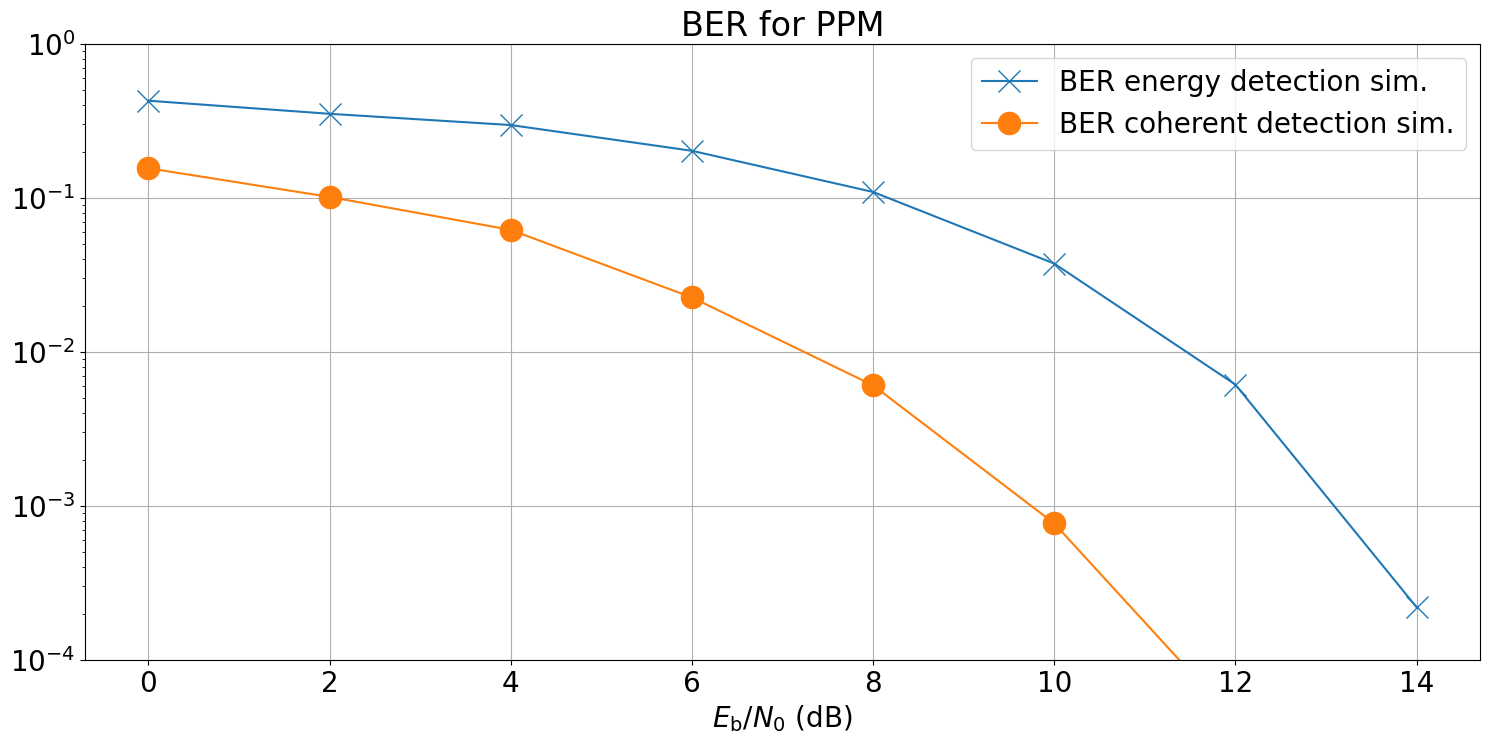

In [17]:
fig, ax = plt.subplots(1,1)

plt.semilogy( Eb_N0_dB, ber_ppm_sim, '-x', ms=16, label='BER energy detection sim.' )
plt.semilogy( Eb_N0_dB, ber_ppm_coherent, '-o', ms=16, label='BER coherent detection sim.' )

plt.grid(1)
plt.legend()
ax.xaxis.get_major_locator().set_params(integer=True)
plt.ylim( 1e-4, 1)
plt.xlabel('$E_\mathrm{b}/N_0$ (dB)')
plt.title('BER for PPM')
plt.show()